# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<br>**Описание данных**

Признаки
-   DateCrawled — дата скачивания анкеты из базы
-	VehicleType — тип автомобильного кузова
-	RegistrationYear — год регистрации автомобиля
-	Gearbox — тип коробки передач
-	Power — мощность (л. с.)
-	Model — модель автомобиля
-	Kilometer — пробег (км)
-	RegistrationMonth — месяц регистрации автомобиля
-	FuelType — тип топлива
-	Brand — марка автомобиля
-	NotRepaired — была машина в ремонте или нет
-	DateCreated — дата создания анкеты
-	NumberOfPictures — количество фотографий автомобиля
-	PostalCode — почтовый индекс владельца анкеты (пользователя)
-	LastSeen — дата последней активности пользователя

**Целевой признак**
<br>Price — цена (евро)




### Оглавление: <a id="toc"></a>

1. [Подготовка данных](#15)
2. [Обучение моделей](#25)
3. [Анализ моделей](#35)
4. [Исследовательский анализ данных](#45)
5. [Общий вывод](#55)



## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import display
import datetime
import random

from lightgbm import LGBMRegressor
import catboost as cb
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.inspection import permutation_importance

#warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'svg'

### Просмотр данных

In [2]:
data = pd.read_csv(r'C:\Users\Vladimir\Documents\Job\Course10\jupyter\cars.csv')
data_orig = data.copy()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Мы видим 354 тысячи записей, 16 столбцов. Есть пропуски. Необходимо преобразование типов. С названием столбцов на превый взглд все вопрядке.

In [4]:
data.sample(5)

DateCrawled  Price VehicleType  RegistrationYear Gearbox  \
122913  2016-03-21 19:50:44   2999       wagon              2005  manual   
54542   2016-04-01 14:55:11   1000       other              2003     NaN   
29772   2016-03-10 17:45:25   3500       small              2006  manual   
337181  2016-04-03 22:47:40   1500         bus              2003  manual   
161587  2016-03-26 18:50:05    800         bus              2000  manual   

        Power     Model  Kilometer  RegistrationMonth  FuelType       Brand  \
122913    101     astra     150000                  5  gasoline        opel   
54542       0     other     150000                  0       NaN  mitsubishi   
29772      68    fiesta      90000                  2  gasoline        ford   
337181    150  carnival     125000                  3    petrol         kia   
161587     75  berlingo     150000                  2    petrol     citroen   

       NotRepaired          DateCreated  NumberOfPictures  PostalCode  \
122913         NaN  2016-03-21 00:00:00                 0       21147   
54542          NaN  2016-04-01 00:00:00                 0       63457   
29772           no  2016-03-10 00:00:00                 0       33415   
337181          no  2016-04-03 00:00:00                 0       17034   
161587          no  2016-03-26 00:00:00                 0        4315   

                   LastSeen  
122913  2016-04-06 22:45:59  
54542   2016-04-07 12:46:36  
29772   2016-03-11 05:44:46  
337181  2016-04-06 00:15:41  
161587  2016-04-06 08:17:22

In [5]:
data.describe()

Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

### Приведение типов

In [6]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
#data['DateCrawled'] = pd.to_datetime(data['DateCrawled'],format='%Y-%m-%d')	
data['VehicleType'] = data['VehicleType'].astype('category')
data['RegistrationYear'] = data['RegistrationYear'].astype('category')
data['Gearbox'] = data['Gearbox'].astype('category')
data['Model'] = data['Model'].astype('category')
data['RegistrationMonth'] = data['RegistrationMonth'].astype('category')
data['FuelType'] = data['FuelType'].astype('category')
data['Brand'] = data['Brand'].astype('category')
data['NotRepaired'] = data['NotRepaired'].astype('category')
data['DateCreated'] =  pd.to_datetime(data['DateCreated'])
data['PostalCode'] = data['PostalCode'].astype('category')
data['NotRepaired'] = data['NotRepaired'].astype('category')
data['LastSeen'] =  pd.to_datetime(data['LastSeen'])
data.dtypes

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                category
RegistrationYear           category
Gearbox                    category
Power                         int64
Model                      category
Kilometer                     int64
RegistrationMonth          category
FuelType                   category
Brand                      category
NotRepaired                category
DateCreated          datetime64[ns]
NumberOfPictures              int64
PostalCode                 category
LastSeen             datetime64[ns]
dtype: object

### Анализ аномалий

In [7]:
category_feature =['RegistrationYear','VehicleType', 'Gearbox', 'Model','RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired','PostalCode']
for column in category_feature:
    print('Имя столбца', column)
    print(data[column].unique())
    print()

Имя столбца RegistrationYear
[1993, 2011, 2004, 2001, 2008, ..., 7100, 8200, 1946, 7500, 3500]
Length: 151
Categories (151, int64): [1993, 2011, 2004, 2001, ..., 8200, 1946, 7500, 3500]

Имя столбца VehicleType
[NaN, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other']
Categories (8, object): ['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other']

Имя столбца Gearbox
['manual', 'auto', NaN]
Categories (2, object): ['manual', 'auto']

Имя столбца Model
['golf', NaN, 'grand', 'fabia', '3er', ..., 'elefantino', 'i3', 'kappa', 'serie_3', 'serie_1']
Length: 251
Categories (250, object): ['golf', 'grand', 'fabia', '3er', ..., 'i3', 'kappa', 'serie_3', 'serie_1']

Имя столбца RegistrationMonth
[0, 5, 8, 6, 7, ..., 2, 3, 1, 4, 9]
Length: 13
Categories (13, int64): [0, 5, 8, 6, ..., 3, 1, 4, 9]

Имя столбца FuelType
['petrol', 'gasoline', NaN, 'lpg', 'other', 'hybrid', 'cng', 'electric']
Categories (7, object): ['petrol', 'gasoline', 'lpg', 'other', 'hyb

Посмотрели на категориальные признаки. На превый взкляд выделение лемм не требуется. Заметили аномальные значения в годах.  Дальше обратим внимание на этот момент.

Так же выявили, что в в столбце месецев -13. Предположим что 0 писался в случае когда небыло данных, но нужно уточнить этот момент у бизнеса.

In [8]:
# цель нашего сервиса предсказывать цены на соверменные автомобили. Поэтому возьмем все авто с возврастом до 40 лет
data = data.query(' RegistrationYear >1980 and RegistrationYear <2021').copy()  

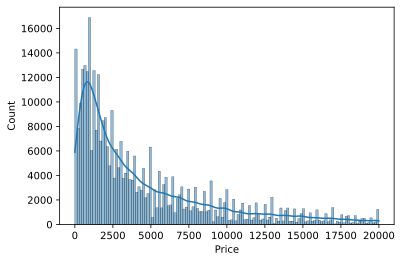

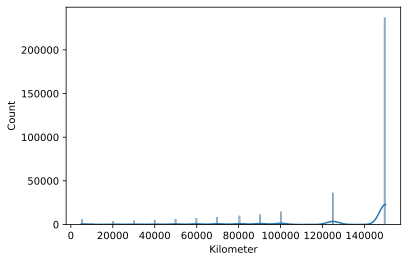

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


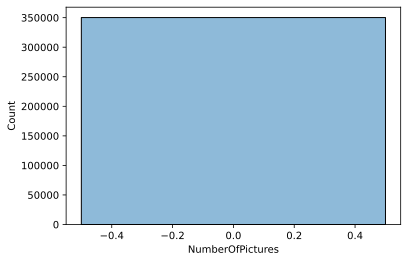

In [9]:
# посмотрим на распределение числовых переменных
numeric_column = data.select_dtypes(include=np.number).columns.values.tolist()
#sns.histplot(data[['RegistrationYear','NotRepaired']], x='RegistrationYear' element='step',kde=True,binwidth=0.9,hue='NotRepaired' );
for column in numeric_column:
    sns.histplot(data[column],kde=True);
    plt.show()

In [10]:
# заметим, что в столбце NumberOfPictures все нули, удалим этот признак
data.drop('NumberOfPictures',axis=1,inplace=True)

C почтовыми кодами, не помешала бы агрегация по регионам/городам, просто коды в отдельности будут мешать модели. Посмотрим на них при анализе признаков, скорее всего удалим пока этот признак. Возможно вернемся к нему позже, т.к. эта ресурсоемкая задача

In [11]:
print(data['PostalCode'].value_counts()[:20])
data.drop('PostalCode',axis=1,inplace=True)

10115    818
65428    612
66333    340
44145    317
32257    316
52525    301
26789    293
78224    290
38518    287
13357    286
48599    280
48249    278
51065    272
60311    272
53757    268
52249    265
60386    262
40764    261
50354    261
61169    258
Name: PostalCode, dtype: int64


Количество удаляемых записей при пороге активности 50 будет равно 144


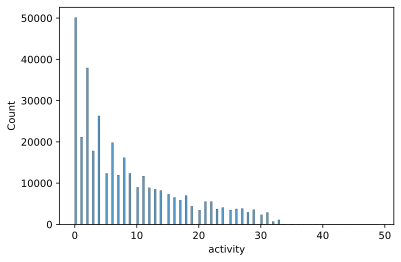

In [12]:
# посмотрим последнюю активность пользователей
data['activity'] = (data['LastSeen'] - data['DateCreated'])
data['activity'] = pd.Series(np.array(data['activity'].values/(3600*24*pow(10,9)), dtype=np.int32), index=data.index)
# Посмотрев на распределение, поняли что в течении 50 дней заходит основная масса пользователей
activity_threshold = 50
activity_shape = data.query('activity<@activity_threshold')['activity'].shape[0]
data['activity'] = data.query('activity<@activity_threshold')['activity']
print(f'Количество удаляемых записей при пороге активности {activity_threshold} будет равно',data.shape[0] - activity_shape)
sns.histplot(data['activity']);
#удалим все данные где небыло активности более 50 дней
data = data.query('activity<@activity_threshold').copy()

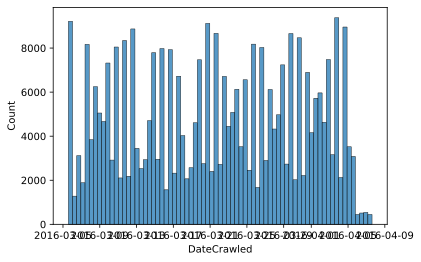

In [13]:
# посмотрим по темпу загрузки данных в базу
sns.histplot(data['DateCrawled']);

In [14]:
data.describe()

Price          Power      Kilometer       activity
count  350080.000000  350080.000000  350080.000000  350080.000000
mean     4394.477042     110.517439  128744.329867       8.626937
std      4494.569829     188.425938   37346.687136       8.367695
min         0.000000       0.000000    5000.000000       0.000000
25%      1050.000000      69.000000  125000.000000       2.000000
50%      2700.000000     105.000000  150000.000000       6.000000
75%      6300.000000     143.000000  150000.000000      13.000000
max     20000.000000   20000.000000  150000.000000      49.000000

### Анализ пропусков

In [15]:
def omission_chek():
    omissions = data.isnull().sum()
    print('Количество столбцов с пропусками равно:',omissions[omissions!=0].count())
    #сохраним перечень столбцов с пропусками для дальнейших действий
    omissions_list = list(omissions[omissions!=0].index.values)
    display(omissions[omissions!=0])

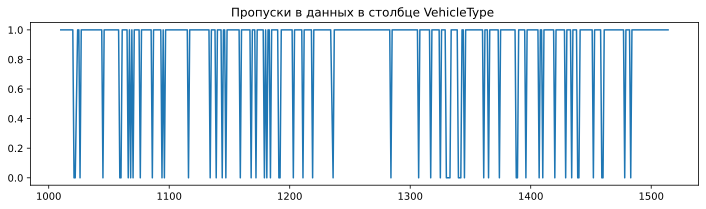

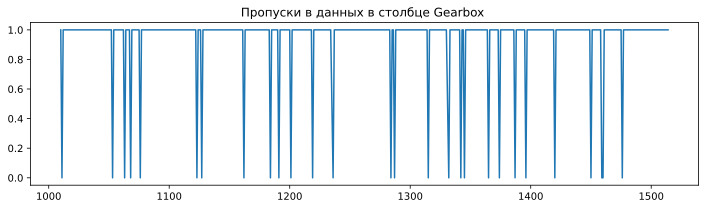

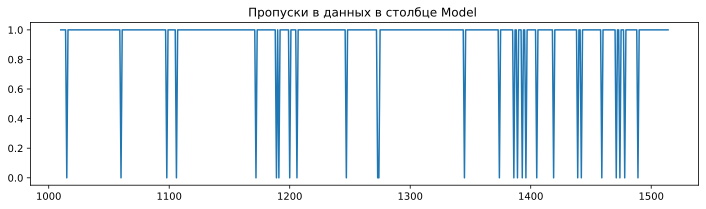

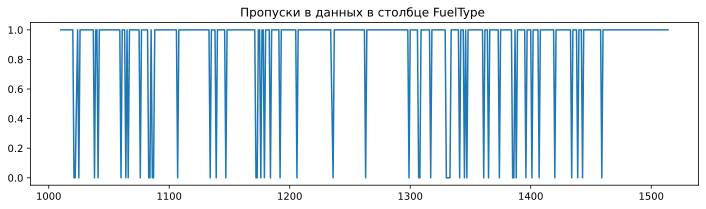

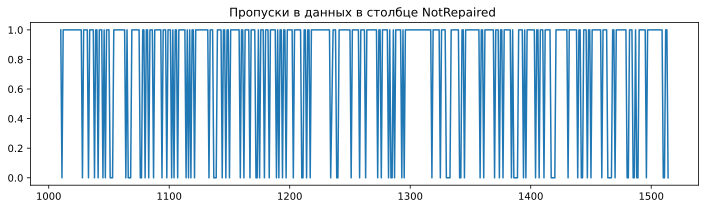

In [16]:
# посмотрим как в БД писались даннаые. Возможно есть закономерость в пропусках.
# пробовал брать по data.DateCrawled - графики были схожие
omissions = data.isnull().sum()
omissions_list = list(omissions[omissions!=0].index.values)
for column in omissions_list:
    data.loc[data[column].isnull(),'tmp_column'] = 0
    data.loc[data[column].notnull(), 'tmp_column'] = 1
    plt.figure(figsize=(12, 3),dpi=100)
    plt.plot(data.index[1000:1500],data['tmp_column'][1000:1500]);
    plt.title(f'Пропуски в данных в столбце {column} ')
    plt.show()
    data.drop(columns=['tmp_column'],axis=1,inplace=True)

Как мы видим нет закономрености в пропусках при записи данных, значит была другая причина.

In [17]:
data['NotRepaired'].isnull()

0          True
1         False
2          True
3         False
4         False
          ...  
354364    False
354365     True
354366    False
354367    False
354368     True
Name: NotRepaired, Length: 350080, dtype: bool

In [18]:
data.describe()

Price          Power      Kilometer       activity
count  350080.000000  350080.000000  350080.000000  350080.000000
mean     4394.477042     110.517439  128744.329867       8.626937
std      4494.569829     188.425938   37346.687136       8.367695
min         0.000000       0.000000    5000.000000       0.000000
25%      1050.000000      69.000000  125000.000000       2.000000
50%      2700.000000     105.000000  150000.000000       6.000000
75%      6300.000000     143.000000  150000.000000      13.000000
max     20000.000000   20000.000000  150000.000000      49.000000

Видим выбросы по датасэту в столбцах по мощности и цене, в дальнейшем посмотрим на межквартильные расстояния и примем решение о замене/удалении значений в выбросах.
Есть отклонения медианных значений от средних.

### Анализ дубликатов

In [19]:
print("Количество полных дубликатов равно ", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print("Количество полных дубликатов после удаления равно ", data.duplicated().sum())

Количество полных дубликатов равно  5
Количество полных дубликатов после удаления равно  0


### Анализ факторов

In [20]:
# посмотрим сколько даннах находится в пределах 3 сигм
for column in ['Price']:
    factor = 3
    upper_lim = data[column].mean () + data[column].std () * factor
    lower_lim = data[column].mean () - data[column].std () * factor
    print(upper_lim,lower_lim)
    display(data[data[column]>upper_lim][column])
#data = data[(data['column'] < upper_lim) & (data['column'] > lower_lim)]


17878.236971379047 -9089.268744570505


1         18300
14        17999
33        18000
172       19750
204       18400
          ...  
354045    20000
354109    17890
354178    19990
354210    17990
354319    19800
Name: Price, Length: 5832, dtype: int64

In [21]:
numeric_column = data.select_dtypes(include=np.number).columns.values.tolist()
numeric_column

['Price', 'Power', 'Kilometer', 'activity']

In [22]:
### получим немножко информации по статистике
# нас интересуют значения межквартильного размаха по некоторым столбцам
stat_dict = {}
def qantile_calc(df,whisker_ratio=3):
    for column_header in numeric_column: 
        stat_25=df[column_header].describe()[4]
        stat_50=df[column_header].describe()[5]
        stat_75=df[column_header].describe()[6]
        whiskers_Q1= (stat_25-(stat_75-stat_25)*whisker_ratio).round(2)
        whiskers_Q3  = (stat_75+(stat_75-stat_25)*whisker_ratio).round(2)
        stat_dict[column_header] =[stat_25,stat_50,stat_75,whiskers_Q1,whiskers_Q3,whisker_ratio]
        
        #Удалим данные, все что выше порога по квантилям.
        check_quantile_data(df,column_header,whiskers_Q1,whiskers_Q3)
        _df = pd.DataFrame.from_dict(stat_dict, orient ='index',columns=['stat_25','stat_50','stat_75','whiskers_Q1','whiskers_Q3','whisker_ratio'] )
    return _df

def check_quantile_data(df,column_header,whiskers_Q1,whiskers_Q3):
    #print(df.shape,column_header,whiskers_Q1,whiskers_Q3)
    print(column_header)
    display(df[df[column_header]>whiskers_Q3])
    
# будем смотреть значения выбросов при 4 межквартильном размахе
display(qantile_calc(data,4).T)    


Price


Empty DataFrame
Columns: [DateCrawled, Price, VehicleType, RegistrationYear, Gearbox, Power, Model, Kilometer, RegistrationMonth, FuelType, Brand, NotRepaired, DateCreated, LastSeen, activity]
Index: []

Power


DateCrawled  Price VehicleType RegistrationYear Gearbox  Power  \
1816   2016-03-22 20:52:00   3200       small             2004  manual   1398   
2102   2016-03-21 11:55:22      0       sedan             1999     NaN   1799   
2781   2016-03-16 00:37:16  19500         suv             2004    auto    450   
3289   2016-03-10 17:46:47  16899       wagon             2003    auto    476   
3746   2016-03-21 14:48:31      0         NaN             2017  manual    750   
...                    ...    ...         ...              ...     ...    ...   
353493 2016-04-02 20:54:21  12500         NaN             2017  manual   2000   
353633 2016-03-23 23:55:21   2400       sedan             2007  manual    650   
354045 2016-03-22 20:48:48  20000       coupe             2006    auto    476   
354260 2016-03-09 17:59:03    399       other             1994     NaN   1103   
354337 2016-03-26 14:38:18  11500       sedan             2004    auto    445   

           Model  Kilometer RegistrationMonth  FuelType          Brand  \
1816     corolla       5000                 6    petrol         toyota   
2102      vectra     150000                 1    petrol           opel   
2781     cayenne     125000                12    petrol        porsche   
3289    e_klasse     150000                 9    petrol  mercedes_benz   
3746         NaN     150000                 8    petrol          smart   
...          ...        ...               ...       ...            ...   
353493     other      60000                 0  gasoline       chrysler   
353633        c2     150000                 8    petrol        citroen   
354045     other     125000                 7    petrol  mercedes_benz   
354260       3er     150000                 0       NaN            bmw   
354337       7er     125000                 0    petrol            bmw   

       NotRepaired DateCreated            LastSeen  activity  
1816            no  2016-03-22 2016-03-22 21:43:26       0.0  
2102           yes  2016-03-21 2016-04-04 04:49:06      14.0  
2781            no  2016-03-16 2016-04-01 22:47:31      16.0  
3289            no  2016-03-10 2016-04-03 18:47:41      24.0  
3746            no  2016-03-21 2016-03-24 03:44:59       3.0  
...            ...         ...                 ...       ...  
353493          no  2016-04-02 2016-04-06 21:44:39       4.0  
353633         NaN  2016-03-23 2016-03-27 01:15:17       4.0  
354045          no  2016-03-22 2016-03-24 05:16:02       2.0  
354260         NaN  2016-03-09 2016-03-17 09:17:08       8.0  
354337         NaN  2016-03-26 2016-04-06 20:45:16      11.0  

[618 rows x 15 columns]

Kilometer


Empty DataFrame
Columns: [DateCrawled, Price, VehicleType, RegistrationYear, Gearbox, Power, Model, Kilometer, RegistrationMonth, FuelType, Brand, NotRepaired, DateCreated, LastSeen, activity]
Index: []

activity


Empty DataFrame
Columns: [DateCrawled, Price, VehicleType, RegistrationYear, Gearbox, Power, Model, Kilometer, RegistrationMonth, FuelType, Brand, NotRepaired, DateCreated, LastSeen, activity]
Index: []

Price  Power  Kilometer  activity
stat_25         1050.0   69.0   125000.0       2.0
stat_50         2700.0  105.0   150000.0       6.0
stat_75         6300.0  143.0   150000.0      13.0
whiskers_Q1   -19950.0 -227.0    25000.0     -42.0
whiskers_Q3    27300.0  439.0   250000.0      57.0
whisker_ratio      4.0    4.0        4.0       4.0

Такое ощущение что данные уже отфильтрованы по порогу в 20 тысяч евро и пробегу 150 тысяч километров. Осталось обрезать данные по мощности. Будем прибавлять 4-кратное межквартильное расстояние, т.к. при 3 кратном мы уже начинаем цеплять уже отфильтрованные данные. 439 лошадиных сил вполне нормальное значение. Удалению подлежит 618 строк.

In [23]:
data = data[data['Power'] <439].copy()

In [24]:
data.corr()

Price     Power  Kilometer  activity
Price      1.000000  0.493464  -0.340621  0.150996
Power      0.493464  1.000000   0.076058  0.075613
Kilometer -0.340621  0.076058   1.000000 -0.067507
activity   0.150996  0.075613  -0.067507  1.000000

Корреляций между числовыми признаками не видно

### Заполнение пропусков и выборосов

In [25]:
# заменим модели с типом other на NaN, т.к. по сути это пропуски
data['Model'].replace('other',np.nan,inplace=True)
data['VehicleType'].replace('other',np.nan,inplace=True)
# c  нулевой мощностью аналогично
data['Power'].replace(0,np.nan,inplace=True)
data['Price'].replace(0,np.nan,inplace=True)

Опустим тот момент что попадались очень редкие маленькие автомобили с мощностью до 40 л.с. и с ценой до 100 евро.  Выходит около 1 тысячи записей. Удалим их.

In [26]:
data = data[~(data['Power'] <40)]
# не будем заполнять NaN у целевого признака признаком
median_group_price = data.groupby(['Model', 'RegistrationYear'])['Price'].transform('median') 
data['Price']=data['Price'].fillna(median_group_price)
omission_chek()
data.dropna(subset= ['Price'],inplace=True)

Количество столбцов с пропусками равно: 7


Price           2628
VehicleType    39401
Gearbox        18607
Power          38692
Model          40769
FuelType       31535
NotRepaired    69105
dtype: int64

In [27]:
median_group_power= data.groupby(['Model'])['Power'].transform('median') 
data['Price']=data['Price'].fillna(median_group_power)
omission_chek()
data.dropna(subset= ['Power'],inplace=True)

Количество столбцов с пропусками равно: 6


VehicleType    38022
Gearbox        17568
Power          37333
Model          38185
FuelType       30234
NotRepaired    67501
dtype: int64

In [28]:
# удалим данные где в строках по нескольку пропусков 15-13=2.
#У нас 6 столбцов c пропусками. 6-2=4. Мы удалим данные, где в одной строке есть 4 пропуска
data = data.dropna(thresh=13)
print(data.shape)

(300362, 15)


В данном случае - 4 столбца это компромис между сохранностью датасэта и количеством сокращаемых пропуков

In [29]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen'],axis=1)

Удалим столбцы с датами.Они модели не нужны. На данном этапе мы обогатили датасэт, для герерации новых фич нужно общение с бизнесом и ресурсы.

In [30]:
omission_chek()
index_iputed_data =data.dropna().index
def randomiseMissingData(df2):
    "randomise missing data for DataFrame (within a column)"
    df = df2.copy()
    for col in ['NotRepaired','VehicleType','Gearbox','Model','FuelType']:
        series = df[col]
        mask = series.isnull()
        samples = random.choices( series[~mask].values , k = mask.sum() )
        df.loc[mask, col] = samples
        
    return df
data = randomiseMissingData(data)
omission_chek()
#посмотрим на заполненные данные
#display(data.iloc[index_iputed_data])

Количество столбцов с пропусками равно: 5


VehicleType    17684
Gearbox         3747
Model          27014
FuelType       14131
NotRepaired    41407
dtype: int64

Количество столбцов с пропусками равно: 0


Series([], dtype: int64)

Заполнили пропуски случайными значениями из каждого столбца. Была идея использовать KNNIputer, но он ищет расстояния между числовыми признаками(которых в нашем датасэте оч. мало), к тому же их нужно масштабировать и заполнять уже масштабируемыми значениями. Ничего страшного в этом нет, но мы не сможем интерпретировать бизнесу заполнение пропусков.

## Обучение моделей

In [31]:
data.sample(3)

Price VehicleType RegistrationYear Gearbox  Power   Model  Kilometer  \
244632  2490.0         suv             2002  manual  114.0  pajero     125000   
7329    2300.0       small             2008  manual   60.0  fiesta      50000   
336227  1855.0       sedan             1999  manual  118.0     3er     150000   

       RegistrationMonth FuelType       Brand NotRepaired  activity  
244632                 6   petrol  mitsubishi         yes      13.0  
7329                   7   petrol        ford          no       0.0  
336227                 8   petrol         bmw          no       4.0

#### Поделим выбоку на трейнувую и тестувую

In [32]:

features = data.drop(['Price'],axis=1)  # извлеките признаки
target = data['Price']

X_train, X_test, y_train, y_test= train_test_split(
features, target, test_size=0.25,shuffle=True, random_state=890)

#сбросим индексы у новых таблиц
for df in X_train, X_test, y_train, y_test:
    df.reset_index(drop=True,inplace =True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(225271, 11) (75091, 11) (225271,) (75091,)


#### Ordinal Encoding and StandardScaler

In [33]:
column_category =X_train.select_dtypes(include='category').columns.to_list()
column_numeric  = X_train.select_dtypes(exclude='category').columns
print(column_category, column_numeric)

['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired'] Index(['Power', 'Kilometer', 'activity'], dtype='object')


In [34]:
encoder_OE_train = OrdinalEncoder()
X_train_OE = X_train.copy()
X_test_OE = X_test.copy()
X_train_OE.loc[:,column_category] = pd.DataFrame(encoder_OE_train.fit_transform(X_train.loc[:,column_category]),columns=column_category,index=X_train.index)
X_test_OE.loc[:,column_category] = pd.DataFrame(encoder_OE_train.transform(X_test.loc[:,column_category]),columns=column_category,index=X_test.index)
X_test_OE

VehicleType  RegistrationYear  Gearbox  Power  Model  Kilometer  \
0              4.0              18.0      1.0   65.0  218.0     150000   
1              0.0              32.0      0.0  140.0  219.0     100000   
2              3.0              17.0      1.0   60.0  172.0     150000   
3              3.0              19.0      1.0  118.0   11.0     150000   
4              4.0              24.0      1.0   80.0   83.0     150000   
...            ...               ...      ...    ...    ...        ...   
75086          6.0              31.0      0.0  143.0  100.0      60000   
75087          0.0              15.0      0.0  110.0  221.0     150000   
75088          6.0              23.0      0.0  136.0   10.0     100000   
75089          0.0              24.0      1.0  129.0  232.0     125000   
75090          6.0              17.0      1.0   75.0   10.0     150000   

       RegistrationMonth  FuelType  Brand  NotRepaired  activity  
0                    4.0       6.0   11.0          0.0       7.0  
1                   12.0       2.0   38.0          0.0       3.0  
2                   11.0       6.0   38.0          0.0      24.0  
3                    0.0       4.0    2.0          0.0       2.0  
4                    2.0       6.0   24.0          0.0       2.0  
...                  ...       ...    ...          ...       ...  
75086                1.0       2.0   30.0          0.0      14.0  
75087                0.0       6.0   38.0          0.0       0.0  
75088                7.0       6.0   25.0          0.0       5.0  
75089               10.0       6.0   36.0          0.0      26.0  
75090                9.0       6.0   25.0          1.0      25.0  

[75091 rows x 11 columns]

In [35]:
scaler = StandardScaler()
X_train_OE =  pd.DataFrame(scaler.fit_transform(X_train_OE),columns=X_train_OE.columns,index=X_train_OE.index)
X_test_OE =  pd.DataFrame(scaler.transform(X_test_OE),columns=X_train_OE.columns,index=X_test_OE.index)
display(X_train_OE.sample(3),X_test_OE.sample(3))

VehicleType  RegistrationYear   Gearbox     Power     Model  \
192750     0.280393         -0.062074  0.500824 -1.156018 -0.016485   
76168     -0.835359         -1.851692  0.500824  1.322406 -1.302665   
114781     1.396146          0.100619  0.500824 -0.622204 -1.345066   

        Kilometer  RegistrationMonth  FuelType     Brand  NotRepaired  \
192750  -1.350493          -0.279708  0.698685 -0.802548    -0.362767   
76168    0.581890          -1.395025  0.698685 -1.400370    -0.362767   
114781   0.581890           1.672096  0.698685  0.318370    -0.362767   

        activity  
192750 -0.216057  
76168   2.519727  
114781 -0.691846

VehicleType  RegistrationYear   Gearbox     Power     Model  Kilometer  \
61395     0.280393         -1.200922  0.500824 -1.156018 -0.285028    0.58189   
72383     1.396146          0.914082  0.500824  2.656942  0.930482    0.58189   
72906    -0.277483          0.263311  0.500824  0.807656 -1.302665    0.58189   

       RegistrationMonth  FuelType     Brand  NotRepaired  activity  
61395          -1.673854  0.698685  0.243642    -0.362767 -0.216057  
72383          -0.558537  0.698685  1.289831    -0.362767  1.806044  
72906           0.556780 -1.451117 -1.400370    -0.362767 -1.048687

Посмотрим как работают базовые модели

### DecisionTreeRegressor

In [36]:
%%time
import time
start_time = time.time()
start = time.time()


from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

model=DecisionTreeRegressor(max_depth=5)
model.fit(X_train_OE,y_train)
predict = model.predict(X_test_OE)
print(mean_squared_error(y_test, predict, squared=False))
#cross_val_score = np.mean(cross_val_score(model,cv_features,cv_target,cv=5))

end = time.time()
print(end - start)

2415.614660696931
0.2931632995605469
Wall time: 293 ms


In [37]:
%%time
from sklearn.ensemble import RandomForestRegressor
modelRF=RandomForestRegressor(max_depth=2, random_state=0)
modelRF.fit(X_train_OE,y_train)
predict = modelRF.predict(X_test_OE)
print(mean_squared_error(y_test, predict, squared=False))

3200.2454923753517
Wall time: 9.05 s


### Lightgbm

In [38]:
%%time 

hyper_param_list = []

def calc_rmse(learning_rate):    
    def rmse(y_true, y_pred):
        return np.sqrt(np.mean((y_true-y_pred)**2))
    learning_rate = round(learning_rate,2)
    rmse = make_scorer(rmse, greater_is_better=False)
    sgb = LGBMRegressor(metric='rmse',random_state = 890,
                        n_jobs = -1,learning_rate = round(learning_rate,2), silent = True)
    _RMSE = np.mean(np.abs(cross_val_score(sgb,X_train,y_train,scoring=rmse)))
    return learning_rate,_RMSE
    #print('The RMSE is: ',_RMSE)
    
for learning_rate in np.linspace(0.01, 1.0, num=20):
    learning_rate,_RMSE = calc_rmse(learning_rate)
    hyper_param_list.append([learning_rate,_RMSE])    
    
hyper_param_list = pd.DataFrame(hyper_param_list,columns=['learning_rate','_RMSE'])
display(hyper_param_list.sort_values(by='_RMSE')[:10])

learning_rate        _RMSE
4            0.22  1546.424095
3            0.17  1547.922516
5            0.27  1548.794772
6            0.32  1554.221843
7            0.37  1558.561568
2            0.11  1559.825310
8            0.43  1575.098559
9            0.48  1580.112371
10           0.53  1590.403650
1            0.06  1600.685142

Wall time: 48 s


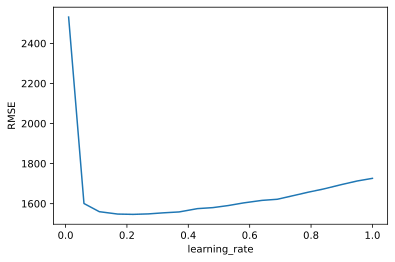

In [39]:
# Посмотрим зависимгость RMSE и Learning Rate
plt.plot(hyper_param_list['learning_rate'],hyper_param_list['_RMSE'])
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.show()

In [40]:
learning_rate,_RMSE = calc_rmse(0.22)
print(f'На тесте при learning_rate {learning_rate} RMSE= {_RMSE}')

На тесте при learning_rate 0.22 RMSE= 1546.424095163764


RMSE 1547.0204277601922


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


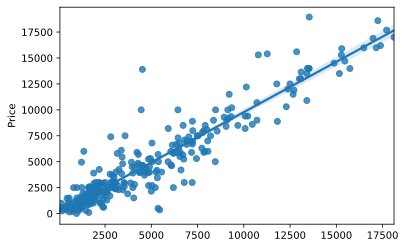

In [41]:
#проверим визуально разбросанность предсказий на тесте
sgb = LGBMRegressor(metric='rmse',random_state = 890,
                        n_jobs = -1,learning_rate = 0.22, silent = True)
sgb.fit(X_train,y_train)
y_pred = sgb.predict(X_test)
print('RMSE',np.sqrt(np.mean((y_pred-y_test)**2)) )
sns.regplot(y_pred[:300], y_test[:300]);
plt.show()

Как показали вычисления модель начинает проскакивать минимум при 'Learning rate' больше 0.4, но в то же время если брать скорость обучения меньше, ты мы начинаем ловить локальные минимумы. 

Как мы видим, случайный лес показал не очень хороший результат. В целом точность предсказания в районе 1600 евро не очень плохой результат.

На диаграмме рассеяния вдино, что при небольшой цене модель предсказывает точнее. А при ценах чуть ниже среднего идет уже большой разброс, а потом опять точнее.

### CatBoostRegressor

In [47]:
%%time

train_dataset = cb.Pool(X_train_OE, y_train) 
test_dataset = cb.Pool(X_test_OE, y_test)


model = cb.CatBoostRegressor(loss_function='RMSE',verbose=None,
                             silent=True)

grid = {'iterations': [50,100],
        'learning_rate':  np.linspace(0.01, 1.0, num=20),
        'depth': [2, 3],
        'l2_leaf_reg': [0.5,1, 3]      
       }

model.cat_features = column_category
model.grid_search(grid, train_dataset,partition_random_seed=890,cv=3)

y_pred = model.predict(X_test_OE)
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))


bestTest = 4714.840986
bestIteration = 49

0:	loss: 4714.8409864	best: 4714.8409864 (0)	total: 446ms	remaining: 1m 46s

bestTest = 2476.110852
bestIteration = 49

1:	loss: 2476.1108523	best: 2476.1108523 (1)	total: 859ms	remaining: 1m 42s

bestTest = 2220.804485
bestIteration = 49

2:	loss: 2220.8044852	best: 2220.8044852 (2)	total: 1.23s	remaining: 1m 37s

bestTest = 2113.930972
bestIteration = 49

3:	loss: 2113.9309724	best: 2113.9309724 (3)	total: 1.65s	remaining: 1m 37s

bestTest = 2068.604992
bestIteration = 49

4:	loss: 2068.6049920	best: 2068.6049920 (4)	total: 2.08s	remaining: 1m 37s

bestTest = 2029.342926
bestIteration = 49

5:	loss: 2029.3429263	best: 2029.3429263 (5)	total: 2.48s	remaining: 1m 36s

bestTest = 1986.404361
bestIteration = 49

6:	loss: 1986.4043606	best: 1986.4043606 (6)	total: 2.88s	remaining: 1m 35s

bestTest = 1967.188676
bestIteration = 49

7:	loss: 1967.1886763	best: 1967.1886763 (7)	total: 3.31s	remaining: 1m 36s

bestTest = 1937.359687
bestIteration = 

#### Feature importance for CatBoost

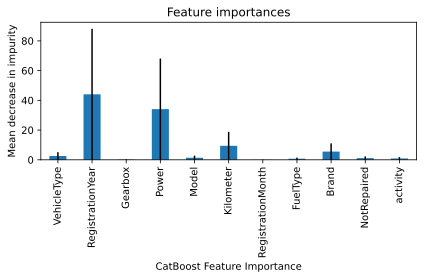

In [43]:
importance = model.feature_importances_
feature_list = X_train.columns.to_list()
feature_results = pd.Series(importance,index= feature_list)
fig, ax = plt.subplots()
feature_results.plot.bar(yerr=feature_results, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xlabel("CatBoost Feature Importance")
fig.tight_layout()

Проведем перебор параметров по бустингу, будем перебирать скорость обучения, глубину деревьев, регуляризацию. Лучший результат по RMSE получился 1736.45 Евро. Так же взглянем не важные признаки при продаже авто - это, мощность, год и пробег.

## Анализ моделей

Как мы видим, что классические модели не приносят высокого качества предсказания. Градиентный Бустинг справляется с этой задачей лучше, т.к. основывается на ансамбле моделей и учится на значениях предыдущей моедели. Естественно что время выполнения у бустинга увеличивается за счет подбора гиперпараметров и итерационного поиска минимума в заданной Loss фукнции. 

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей